# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
from skimage import io

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5734567166532533276
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281304781
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2436189091347246651
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

In [4]:
import cv2

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, image_height, image_width, img_frames,aug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_frames
    
    
    
    if(aug==True):
        if source_path.split('/')[-1]=='train':
                augment=True
        else:
            augment=False
    else:
        augment=False
    
    
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size
       
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data_aug = np.zeros((batch_size,len(img_idx),image_height,image_width,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resize=imresize(image,(image_width,image_height,3))
                    
                    
                    batch_data[folder,idx,:,:,0] = image_resize[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resize[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resize[:,:,2]/255 #normalise and feed in the image
                    
                    if (augment):
                        x, y = np.random.randint(0, 40, 2)
                        pts1 = np.float32([[x,y], [image_width-x,y], [x,image_height-y], [image_width-x,image_width-y]])
                        pts2 = np.float32([[0,0],[image_width,0],[0,image_height],[image_width,image_height]])

                        M = cv2.getPerspectiveTransform(pts1,pts2)

                        shifted = cv2.warpPerspective(image_resize,M,(image_width,image_height))











                        batch_data_aug[folder,idx,:,:,0] = shifted[:,:,0]/255
                        batch_data_aug[folder,idx,:,:,1] = shifted[:,:,1]/255
                        batch_data_aug[folder,idx,:,:,2] = shifted[:,:,2]/255
                    
                    
                    
                        #shifted = cv2.warpAffine(image, 
                                             #np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            #(image.shape[1], image.shape[0]))
                    
                        #gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        #x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        #x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                        #cropped=shifted[x0:x1,y0:y1,:]

                        #image_resized=imresize(cropped,(image_height,image_width,3))

                        #shifted = cv2.warpAffine(image_resized, 
                        #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                        #                        (image_resized.shape[1], image_resized.shape[0]))

                        #batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        #batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        #batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            #batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
                    
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                

                    #fig, axes = plt.subplots(nrows=1, ncols=2)
                    #axes[0].imshow(shifted)   
                    #axes[1].imshow(batch_data_aug[folder,idx,:,:,:])
                    
                
            
            if(augment):        
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])        
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        
        
        # write the code for the remaining data points which are left after full batches
        
        if(len(t)%batch_size!=0):
            print(t[0])
            last_read=((batch+1)*batch_size)
            batch_size_new=len(t)%batch_size
            

            
            
            batch_data = np.zeros((batch_size_new,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size_new,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size_new): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + last_read].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + last_read].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resize=imresize(image,(image_height,image_width,3))
                    batch_data[folder,idx,:,:,0] = image_resize[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = image_resize[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = image_resize[:,:,2]/255 #normalise and feed in the image
                        
                batch_labels[folder, int(t[folder + (batch*batch_size_new)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
import matplotlib.pyplot as plt
def plot(model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(model.history['loss'])   
    axes[0].plot(model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(model.history['categorical_accuracy'])   
    axes[1].plot(model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [10]:
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]

In [11]:
a=generator(train_path, train_doc, 20,100,100,image_frames,aug=True)

In [12]:
batch_data, batch_labels=next(a)

Source path =  Project_data/train ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [13]:
print((batch_data).shape)

(40, 25, 100, 100, 3)


In [14]:
import matplotlib.pyplot as plt

In [15]:
batch_labels.shape

(40, 5)

### Testing augmentation

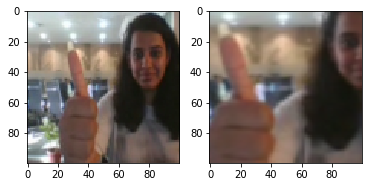

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[6,11,:,:,:])   
axes[1].imshow(batch_data[26,11,:,:,:])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

    
def define_model(frames_to_sample,image_height,image_width):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [18]:
model=define_model(25,100,100)
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 25, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 50, 50, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 50, 50, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 50, 50, 32)    128       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [19]:
image_height=100
image_width=100
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]

train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames)
val_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Performing ablation experiments

In [75]:
image_height=160
image_width=160
image_frames=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [76]:
model=define_model(30,160,160)

In [50]:
# md1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Getting OOM error when processing 160x160 image. Changing the resolution

#### The above used resolution is too big to be fed as an input to the neural network. It results in the ResourceExhaustedError exception. 

In [62]:
image_height=150
image_width=150
image_frames=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, train_doc, batch_size,image_height, image_width, image_frames)

In [63]:
model=define_model(30,150,150)

In [57]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
#md2=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#### Still getting OOM error with the current resolution. Next, we will try decreasing it.

In [72]:
image_height=140
image_width=140
image_frames=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, train_doc, batch_size,image_height, image_width, image_frames)

In [73]:
model=define_model(30,140,140)

In [58]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [1]:
#md3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#### Changing the frame size to 140*140 doesn't seem to work. Still getting OOM error.

In [60]:
image_height=130
image_width=130
image_frames=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [61]:
model=define_model(30,130,130)

In [62]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [64]:
#md4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#### Resolution of 130*130 is still to large for memory and throws a OOM(ResourceExhaustedError) error.

#### Next up, we will work with a 120*120 frame size to see if it fits into the memory.

In [78]:
image_height=120
image_width=120
image_frames=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [79]:
model=define_model(30,120,120)

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [67]:
#md5=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#### Resolution of 120*120 is still to large for memory and throws a OOM(ResourceExhaustedError) error.

In [77]:
image_height=110
image_width=110
image_frames=[i for i in range(0,30)]
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [78]:
model=define_model(30,110,110)

In [68]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [79]:
md6=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size =Source path =  Project_data/train ; batch size =Epoch 1/2
 30
 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/23 [=>............................] - ETA: 2:27 - loss: 2.2918 - categorical_accuracy: 0.2250WIN_20180926_17_29_34_Pro_Right_Swipe_new;Right_Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 5/23 [=====>........................] - ETA: 1:47 - loss: 2.0754 - categorical_accuracy: 0.2800WIN_20180925_17_42_34_Pro_Thumbs_Up_new;Thumbs_Up_new;4

21/23 [==========================>...] - ETA: 9s - loss: 1.6657 - categorical_accuracy: 0.3921 WIN_20180907_16_22_23_Pro_Right Swipe_new;Right Swipe_new;1

23/23 [==============================] - 107s 5s/step - loss: 1.7094 - categorical_accuracy: 0.3936 - val_loss: 1.7457 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2021-02-0809_36_09.430274/model-00001-1.64829-0.39607-1.74568-0.46000.h5
WIN_20180926_17_01_52_Pro_Right_Swipe_new;Right_Swipe_new;1

Epoch 2/2
21/23 [==========================>...] - ETA: 8s - loss: 1.1492 - categorical_accuracy: 0.5603 WIN_20180926_16_51_55_Pro_Left_Swipe_new;Left_Swipe_new;0

23/23 [==============================] - 94s 4s/step - loss: 1.1935 - categorical_accuracy: 0.5672 - val_loss: 1.5592 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2021

#### The input with the resolution 110*110 works well for us. However, it seems to be overfitting.Let's try something different now and see the effects of change in number of frame's to sample on model performance

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 110, 110, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 110, 110, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 110, 110, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 15, 55, 55, 16)    0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 55, 55, 32)    4128      
_________________________________________________________________
activation_30 (Activation)   (None, 15, 55, 55, 32)    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 15, 55, 55, 32)    128       
__________

#### The number of training parameter is decently low.So, in our next set of experiments we will observe the effects of number of frames to sample and batch size on the accuracy and the model memory footprint.

#### We will start off by decreasing the number of frames we were previously sending in as input into the model.

In [51]:
image_height=110
image_width=110
image_frames=[int(round(i)) for i in np.arange(0,30,1.5)]
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [52]:
model=define_model(len(image_frames),110,110)

In [69]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [50]:
md7= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/2


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


WIN_20180907_15_50_39_Pro_Right Swipe_new;Right Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 4/23 [====>.........................] - ETA: 1:23 - loss: 2.0140 - categorical_accuracy: 0.2875WIN_20180907_15_42_17_Pro_Stop Gesture_new;Stop Gesture_new;2

21/23 [==========================>...] - ETA: 6s - loss: 1.6520 - categorical_accuracy: 0.3802WIN_20180907_16_29_13_Pro_Stop Gesture_new;Stop Gesture_new;2

23/23 [==============================] - 73s 3s/step - loss: 1.6950 - categorical_accuracy: 0.3827 - val_loss: 1.7449 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2021-02-0809_02_40.930436/model-00001-1.63966-0.38473-1.74490-0.51000.h5
Epoch 2/2
WIN_20180907_15_30_06_Pro_Right Swipe_new;Right Swipe_new;1

21/23 [==========================>...] - ETA: 5s - loss: 1.2565 - categorical_accuracy: 0.5119WIN_20180907_16_19_31_Pro_Right Swipe_new;Right Swipe_new;1

23/23 [==============================] - 63s 3s/step - loss: 1.3805 - categorical_accuracy: 0.4907 - val_loss: 1.2465 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_in

#### We see that the accuracy decreases but not by a lot when the number of frames being sampled decreases to 20.

#### We shall now observe what happens when the number of frames to sample are further decreased to 16.

In [82]:
image_height=110
image_width=110
image_frames=[int(round(i)) for i in np.arange(0,30,1.9)]
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [83]:
model=define_model(len(image_frames),110,110)

In [70]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [84]:
md8= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  Project_data/train ; batch size = 30
Epoch 1/2Project_data/val ; batch size = 30



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


WIN_20180925_17_43_46_Pro_Right_Swipe_new;Right_Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 4/23 [====>.........................] - ETA: 1:07 - loss: 2.0382 - categorical_accuracy: 0.3000WIN_20180925_17_48_16_Pro_Thumbs_Down_new;Thumbs_Down_new;3

21/23 [==========================>...] - ETA: 5s - loss: 1.6048 - categorical_accuracy: 0.3873WIN_20180926_17_31_45_Pro_Thumbs_Up_new;Thumbs_Up_new;4

23/23 [==============================] - 58s 3s/step - loss: 1.7074 - categorical_accuracy: 0.3739 - val_loss: 1.9015 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2021-02-0809_36_09.430274/model-00001-1.61171-0.38927-1.90153-0.46000.h5
WIN_20180907_16_00_42_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0

Epoch 2/2
21/23 [==========================>...] - ETA: 4s - loss: 1.2088 - categorical_accuracy: 0.5302WIN_20180925_17_53_03_Pro_Stop_new;Stop_new;2

23/23 [==============================] - 48s 2s/step - loss: 1.2436 - categorical_accuracy: 0.5272 - val_loss: 1.4589 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to mo

#### It seems that dropping the number of frames being sampled increases the accuracy of the model. But since the number of epochs used for this experiment is low so the results are a bit inconclusive. However, we will take this into account in our future experiments.

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 110, 110, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 110, 110, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 110, 110, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 55, 55, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 55, 55, 32)     4128      
_________________________________________________________________
activation_34 (Activation)   (None, 8, 55, 55, 32)     0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 8, 55, 55, 32)     128       
__________

#### Also, sampling lesser number of frames doesn't decrease the number of trainaible parameter either.

#### Hence, based on these observations, there seems to be a correlation between model performance and the number of frames being sampled.

#### Now, we will keep our frame size ,number of frames to sample fixed while experimenting with the batch size

In [78]:
image_height=110
image_width=110
image_frames=[int(round(i)) for i in np.arange(0,30)]
batch_size=40
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [79]:
model=define_model(len(image_frames),110,110)

In [80]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [81]:
md9= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =   ; batch size = 40
Project_data/train ; batch size = 40
Epoch 1/2


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


WIN_20180907_15_52_05_Pro_Thumbs Up_new;Thumbs Up_new;4



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/17 [====>.........................] - ETA: 1:46 - loss: 2.5405 - categorical_accuracy: 0.2000WIN_20180926_17_04_53_Pro_Stop_new;Stop_new;2

 5/17 [=======>......................] - ETA: 1:27 - loss: 2.4432 - categorical_accuracy: 0.2075WIN_20180907_15_45_04_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0

15/17 [=========================>....] - ETA: 12s - loss: 2.1558 - categorical_accuracy: 0.2758WIN_20180925_17_41_54_Pro_Thumbs_Up_new;Thumbs_Up_new;4

17/17 [==============================] - 105s 6s/step - loss: 2.1872 - categorical_accuracy: 0.2663 - val_loss: 1.7443 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-02-0810_45_39.832185/model-00001-2.17546-0.27015-1.74434-0.29000.h5
WIN_20180925_17_33_30_Pro_Thumbs_Down_new;Thumbs_Down_new;3

Epoch 2/2
15/17 [=========================>....] - ETA: 10s - loss: 1.6602 - categorical_accuracy: 0.3708WIN_20180907_16_12_53_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;

#### The batch size of 40 fits into the memory.Let's see what happens when the bacth size is gradually increased

In [84]:
image_height=110
image_width=110
image_frames=[int(round(i)) for i in np.arange(0,30)]
batch_size=50
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [85]:
model=define_model(len(image_frames),110,110)

In [86]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [87]:
md10= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 50
Source path =  Project_data/train ; batch size = Epoch 1/2
50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 20s - loss: 2.1042 - categorical_accuracy: 0.2658WIN_20180926_17_42_50_Pro_Thumbs_Down_new;Thumbs_Down_new;3



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 148s 11s/step - loss: 2.0721 - categorical_accuracy: 0.2584 - val_loss: 1.5490 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2021-02-0810_45_39.832185/model-00001-2.08135-0.26961-1.54901-0.43000.h5
Epoch 2/2
12/14 [========================>.....] - ETA: 27s - loss: 1.6945 - categorical_accuracy: 0.3592WIN_20180926_17_17_07_Pro_Thumbs_Down_new;Thumbs_Down_new;3

14/14 [==============================] - 184s 13s/step - loss: 1.6909 - categorical_accuracy: 0.3558 - val_loss: 1.4278 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2021-02-0810_45_39.832185/model-00002-1.68279-0.35872-1.42777-0.47000.h5


#### Increasing the batch size again

In [88]:
image_height=110
image_width=110
image_frames=[int(round(i)) for i in np.arange(0,30)]
batch_size=60
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [89]:
model=define_model(len(image_frames),110,110)

In [90]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [91]:
md11= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 60
Source path =  Project_data/trainEpoch 1/2
 ; batch size = 60


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


WIN_20180926_17_21_48_Pro_Left_Swipe_new;Left_Swipe_new;0



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 1/12 [=>............................] - ETA: 5:19 - loss: 2.6763 - categorical_accuracy: 0.1667WIN_20180907_15_50_39_Pro_Right Swipe_new;Right Swipe_new;1

 2/12 [====>.........................] - ETA: 2:56 - loss: 2.4461 - categorical_accuracy: 0.2125WIN_20180926_17_29_34_Pro_Right_Swipe_new;Right_Swipe_new;1

 3/12 [======>.......................] - ETA: 2:27 - loss: 2.3623 - categorical_accuracy: 0.2222WIN_20180926_16_37_56_Pro_Stop_new;Stop_new;2

 4/12 [=========>....................] - ETA: 2:11 - loss: 2.3651 - categorical_accuracy: 0.2125WIN_20180925_17_43_01_Pro_Left_Swipe_new;Left_Swipe_new;0

10/12 [========================>.....] - ETA: 33s - loss: 2.2006 - categorical_accuracy: 0.2433WIN_20180907_16_22_03_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0

12/12 [==============================] - 192s 16s/step - loss: 2.2112 - categorical_accuracy: 0.2314 - val_loss: 2.1835 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-02-

#### Based on the above experiments, it seems that the increase in batch size negatively affects the model performance as the validation accuracy has decreased as we have increased the batch size.

#### Based on our initial experiments we can draw the following inferences :-
<ul>
    <li>Increase in frame size results in an <b>increment</b> of both our model performace and model memory footprint.</li>
    <li>There seems to be a <b>correlation</b> between the model performance and the number of frames being sampled</li>
    <li>Finally, the increase in batch size seems to negatively affect the model performance.</li>
</ul>

#### Now, we will be performing a few different permutations in order to arrive at a decent model.

In [93]:
image_height=120
image_width=120
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [94]:
model=define_model(25,120,120)

In [95]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 25, 120, 120, 8)   656       
_________________________________________________________________
activation_49 (Activation)   (None, 25, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 25, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 12, 60, 60, 8)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 12, 60, 60, 16)    3472      
_________________________________________________________________
activation_50 (Activation)   (None, 12, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 12, 60, 60, 16)    64        
__________

In [97]:
mdz=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 10s - loss: 1.9291 - categorical_accuracy: 0.3031WIN_20180907_16_02_21_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 170s 5s/step - loss: 1.9376 - categorical_accuracy: 0.3061 - val_loss: 1.4748 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2021-02-0810_45_39.832185/model-00001-1.92353-0.30537-1.47478-0.36000.h5
Epoch 2/25
32/34 [===========================>..] - ETA: 4s - loss: 1.4383 - categorical_accuracy: 0.4367WIN_20180926_17_04_58_Pro_Right_Swipe_new;Right_Swipe_new;1

34/34 [==============================] - 78s 2s/step - loss: 1.4704 - categorical_accuracy: 0.4268 - val_loss: 1.2952 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2021-02-0810_45_39.832185/model-00002-1.43988-0.43840-1.29522-0.49000.h5
Epoch 3/25
32/34 [===========================>..] - ETA: 5s - loss: 1.2465 - categorical_accuracy: 0.5125WIN_20180926_16_40_01_Pro_Thumbs_Up_new;Thumbs_Up_new;4

34/34 [==============================] - 85s 2s/step - loss: 1.2745 - categorical_accuracy: 0.5070 - val_loss: 1.1566 - val_categorical_a

#### The validation accuracy = 63% and training accuracy is 72% for the above model.

#### This model doesn't have any augmentations done on its input and it seems to be over-fitting.

#### For our next experiment we will use the same model with augmentation enabled.

In [27]:
### Model 3

In [52]:
image_height=120
image_width=120
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [53]:
model=define_model(25,120,120)

In [54]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 25, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 25, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 12, 60, 60, 32)    4128      
_________________________________________________________________
activation_26 (Activation)   (None, 12, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 12, 60, 60, 32)    128       
__________

In [56]:
md1=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size =Epoch 1/3
 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 5s - loss: 1.6743 - categorical_accuracy: 0.3992WIN_20180926_17_20_41_Pro_Stop_new;Stop_new;2



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 95s 3s/step - loss: 1.7007 - categorical_accuracy: 0.3856 - val_loss: 2.2860 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2021-02-0812_36_52.539199/model-00001-1.67300-0.39607-2.28605-0.33000.h5
Epoch 2/3
32/34 [===========================>..] - ETA: 5s - loss: 1.2374 - categorical_accuracy: 0.5211WIN_20180907_16_42_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0

34/34 [==============================] - 84s 2s/step - loss: 1.2106 - categorical_accuracy: 0.5371 - val_loss: 0.8829 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2021-02-0812_36_52.539199/model-00002-1.22867-0.52457-0.88289-0.67000.h5
Epoch 3/3
32/34 [===========================>..] - ETA: 5s - loss: 1.0623 - categorical_accuracy: 0.5898WIN_20180926_17_28_52_Pro_Right_Swipe_new;Right_Swipe_new;1

34/34 [==============================] - 89s 3s/step - loss: 1.1122 - categorical_accuracy: 0.5740 - val_los

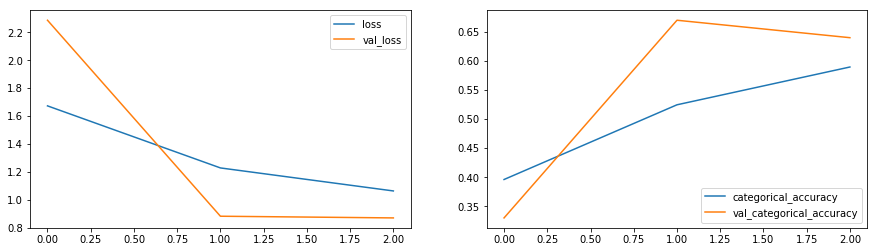

In [57]:
plot(md1)

#### The following model was run for a lesser number of epochs.But, the validation and training accuracy seems to be promising.

### Changing number of frames and increasing resolution

In [ ]:
####model 4

In [58]:
image_height=130
image_width=130
image_frames=[int(round(i)) for i in np.arange(1,29,1.5)]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [59]:
model=define_model(19,130,130)

In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 19, 130, 130, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 19, 130, 130, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 19, 130, 130, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 9, 65, 65, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 9, 65, 65, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 9, 65, 65, 32)     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 9, 65, 65, 32)     128       
__________

In [61]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20Epoch 1/3



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 4s - loss: 1.6353 - categorical_accuracy: 0.4141WIN_20180907_16_06_43_Pro_Stop Gesture_new;Stop Gesture_new;2



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 79s 2s/step - loss: 1.6756 - categorical_accuracy: 0.4128 - val_loss: 1.7996 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2021-02-0812_36_52.539199/model-00001-1.62826-0.41497-1.79961-0.42000.h5
Epoch 2/3
32/34 [===========================>..] - ETA: 4s - loss: 1.1675 - categorical_accuracy: 0.5594WIN_20180926_17_19_35_Pro_Right_Swipe_new;Right_Swipe_new;1

34/34 [==============================] - 70s 2s/step - loss: 1.2447 - categorical_accuracy: 0.5431 - val_loss: 1.0359 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2021-02-0812_36_52.539199/model-00002-1.17179-0.55782-1.03592-0.58000.h5
Epoch 3/3
32/34 [===========================>..] - ETA: 4s - loss: 1.0425 - categorical_accuracy: 0.5922WIN_20180925_17_27_22_Pro_Thumbs_Up_new;Thumbs_Up_new;4

34/34 [==============================] - 74s 2s/step - loss: 1.0434 - categorical_accuracy: 0.5857 - val_loss: 0.7801 - val_categorical_accu

## Adding More Layers, Without Augmentation

In [84]:
###model7

In [79]:
def define_model(frames_to_sample,image_height,image_width):
        filtersize=(3,3,3)
        dense_neurons=64
        dropout=0.25
        
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [80]:
image_height=100
image_width=100
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [81]:
model=define_model(25,100,100)

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 25, 100, 100, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 25, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 25, 100, 100, 16)  64        
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 25, 100, 100, 16)  6928      
_________________________________________________________________
activation_46 (Activation)   (None, 25, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 25, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 12, 50, 50, 16)    0         
__________

In [83]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [85]:
md7=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/3


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


WIN_20180926_17_05_38_Pro_Left_Swipe_new;Left_Swipe_new;0



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 5/23 [=====>........................] - ETA: 1:41 - loss: 2.2602 - categorical_accuracy: 0.2600WIN_20180926_17_09_45_Pro_Thumbs_Down_new;Thumbs_Down_new;3

21/23 [==========================>...] - ETA: 6s - loss: 1.8265 - categorical_accuracy: 0.3444 WIN_20180907_16_27_05_Pro_Right Swipe_new;Right Swipe_new;1

23/23 [==============================] - 80s 3s/step - loss: 1.8295 - categorical_accuracy: 0.3508 - val_loss: 8.1907 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-02-0812_36_52.539199/model-00001-1.81743-0.35143-8.19071-0.22000.h5
WIN_20180926_17_06_40_Pro_Thumbs_Up_new;Thumbs_Up_new;4

Epoch 2/3
21/23 [==========================>...] - ETA: 4s - loss: 1.3959 - categorical_accuracy: 0.4587WIN_20180926_18_09_50_Pro_Right_Swipe_new;Right_Swipe_new;1

23/23 [==============================] - 53s 2s/step - loss: 1.3981 - categorical_accuracy: 0.4442 - val_loss: 8.0348 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2021

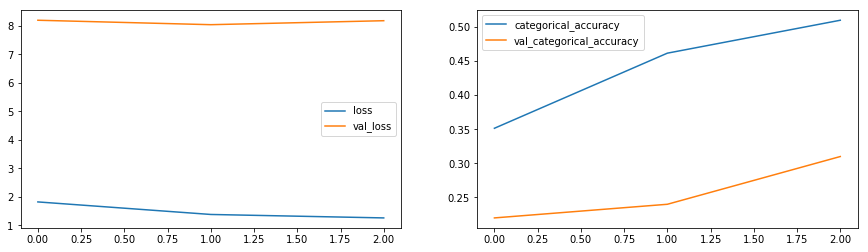

In [87]:
plot(md7)

## Adding More Layers with augmentation enabled.

In [62]:
def define_model(frames_to_sample,image_height,image_width):
        filtersize=(3,3,3)
        dense_neurons=64
        dropout=0.25
        
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [63]:
image_height=100
image_width=100
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [64]:
model=define_model(25,100,100)

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 25, 100, 100, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 25, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 25, 100, 100, 16)  64        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 25, 100, 100, 16)  6928      
_________________________________________________________________
activation_38 (Activation)   (None, 25, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 25, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 12, 50, 50, 16)    0         
__________

In [57]:
md12=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/3


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/34 [>.............................] - ETA: 2:57 - loss: 2.3655 - categorical_accuracy: 0.1667WIN_20180925_17_49_40_Pro_Stop_new;Stop_new;2



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 5/34 [===>..........................] - ETA: 2:14 - loss: 2.1678 - categorical_accuracy: 0.2400WIN_20180907_16_29_12_Pro_Thumbs Down_new;Thumbs Down_new;3

21/34 [=================>............] - ETA: 50s - loss: 1.9554 - categorical_accuracy: 0.2968WIN_20180926_17_13_59_Pro_Thumbs_Down_new;Thumbs_Down_new;3

34/34 [==============================] - 126s 4s/step - loss: 1.7755 - categorical_accuracy: 0.3395 - val_loss: 1.4107 - val_categorical_accuracy: 0.4923

Epoch 00001: saving model to model_init_2021-02-0815_01_47.572012/model-00001-1.77918-0.34897-1.41070-0.49231.h5
WIN_20180907_15_43_36_Pro_Thumbs Up_new;Thumbs Up_new;4

Epoch 2/3
10/34 [=======>......................] - ETA: 1:20 - loss: 1.5266 - categorical_accuracy: 0.4083WIN_20180926_17_24_54_Pro_Thumbs_Down_new;Thumbs_Down_new;3

33/34 [============================>.] - ETA: 3s - loss: 1.3889 - categorical_accuracy: 0.4813WIN_20180907_16_18_18_Pro_Right Swipe_new;Right Swipe_new;1

WIN_20180926_17_09_45_Pro_Thumbs_Down_ne

#### Based on our initial experiments we can draw the following inferences :-
<ul>
    <li>Model with augmentations seems to perform better performance eventhough the memory footprint remains the same</li>
    <li>There doessn't seem to be any benefit in increasing the number of layers for this problem statement</li>
</ul>

### Using our old model without any added layers and a few architectural changes.

In [40]:
def define_model(frames_to_sample,image_height,image_width):
        
        
        dropout=0.25
        dense_neurons=64
        
        
        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
image_height=120
image_width=120
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [30]:
model=define_model(25,120,120)

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 25, 120, 120, 8)   656       
_________________________________________________________________
activation_9 (Activation)    (None, 25, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 25, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 12, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 12, 60, 60, 16)    3472      
_________________________________________________________________
activation_10 (Activation)   (None, 12, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 12, 60, 60, 16)    64        
__________

In [33]:
mdy=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/23 [==>...........................] - ETA: 2:44 - loss: 2.5496 - categorical_accuracy: 0.1333WIN_20180926_17_24_12_Pro_Right_Swipe_new;Right_Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 5/23 [=====>........................] - ETA: 2:33 - loss: 2.4533 - categorical_accuracy: 0.1700WIN_20180926_17_32_40_Pro_Stop_new;Stop_new;2

21/23 [==========================>...] - ETA: 14s - loss: 2.0103 - categorical_accuracy: 0.2873WIN_20180907_15_49_56_Pro_Right Swipe_new;Right Swipe_new;1

23/23 [==============================] - 168s 7s/step - loss: 2.0710 - categorical_accuracy: 0.2802 - val_loss: 1.5574 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2021-02-0810_45_39.832185/model-00001-2.00783-0.29176-1.55743-0.37000.h5
Epoch 2/25
WIN_20180907_16_02_09_Pro_Thumbs Down_new;Thumbs Down_new;3

21/23 [==========================>...] - ETA: 7s - loss: 1.5104 - categorical_accuracy: 0.4103 WIN_20180926_17_43_07_Pro_Left_Swipe_new;Left_Swipe_new;0

23/23 [==============================] - 89s 4s/step - loss: 1.5094 - categorical_accuracy: 0.3971 - val_loss: 1.4252 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2021-02-0810_

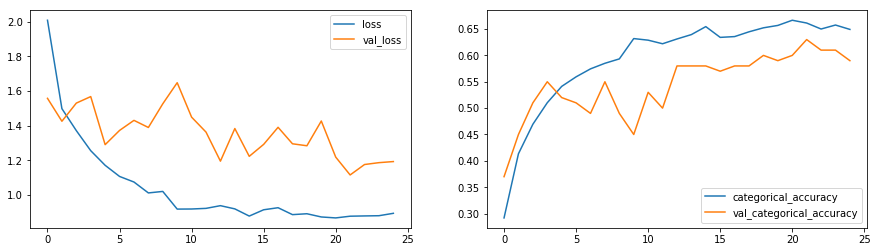

In [34]:
plot(mdy)

#### After 25 epochs, the highest training accuracy this model could achieve was 66% while the highest validation accuracy was 62%.

#### The one thing we can take away from this model is that it is not over-fitting a lot and maybe increasing the epochs might help achieve that.

### Increasing batch size to check its effect over multiple epochs.

In [42]:
image_height=120
image_width=120
image_frames=[int(round(i)) for i in np.arange(0,30,1.5)] 
batch_size=50
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [43]:
model=define_model(len(image_frames),120,120)

In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation_17 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_18 (Activation)   (None, 10, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 10, 60, 60, 16)    64        
__________

In [45]:
mdx=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 50
Epoch 1/25
 Project_data/val ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/23 [==============>...............] - ETA: 1:05 - loss: 1.9999 - categorical_accuracy: 0.2508WIN_20180925_17_36_58_Pro_Right_Swipe_new;Right_Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 125s 5s/step - loss: 1.8569 - categorical_accuracy: 0.2875 - val_loss: 2.0147 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-02-0810_45_39.832185/model-00001-1.84912-0.28965-2.01474-0.30000.h5
Epoch 2/25
 3/23 [==>...........................] - ETA: 1:28 - loss: 1.4909 - categorical_accuracy: 0.4400WIN_20180925_18_01_30_Pro_Stop_new;Stop_new;2

17/23 [=====================>........] - ETA: 27s - loss: 1.4943 - categorical_accuracy: 0.4242WIN_20180907_16_40_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0

23/23 [==============================] - 106s 5s/step - loss: 1.5022 - categorical_accuracy: 0.4321 - val_loss: 1.5250 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2021-02-0810_45_39.832185/model-00002-1.41261-0.44779-1.52504-0.43000.h5
Epoch 3/25
 8/23 [=========>....................] - ETA: 1:17 - loss: 1.2647 - categorical_accuracy: 0.5000WIN_20180925_17_22_

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation_17 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_18 (Activation)   (None, 10, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 10, 60, 60, 16)    64        
__________

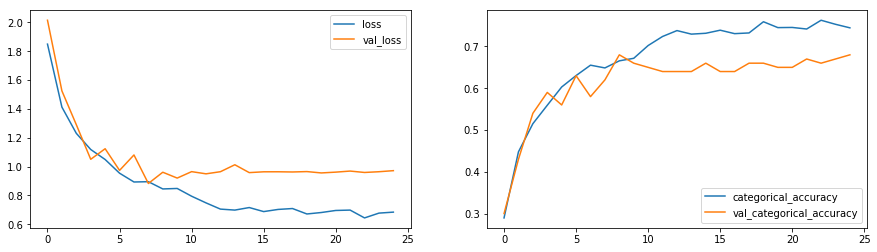

In [49]:
plot(mdx)

#### Validation accuracy comes up to 68% and training accuracy comes upto 72%.

### Decreasing the number of batches to see its effect over multiple epochs.

In [93]:
image_height=120
image_width=120
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [94]:
model=define_model(25,120,120)

In [95]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 25, 120, 120, 8)   656       
_________________________________________________________________
activation_49 (Activation)   (None, 25, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 25, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 12, 60, 60, 8)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 12, 60, 60, 16)    3472      
_________________________________________________________________
activation_50 (Activation)   (None, 12, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 12, 60, 60, 16)    64        
__________

In [97]:
mdz=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 10s - loss: 1.9291 - categorical_accuracy: 0.3031WIN_20180907_16_02_21_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 170s 5s/step - loss: 1.9376 - categorical_accuracy: 0.3061 - val_loss: 1.4748 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2021-02-0810_45_39.832185/model-00001-1.92353-0.30537-1.47478-0.36000.h5
Epoch 2/25
32/34 [===========================>..] - ETA: 4s - loss: 1.4383 - categorical_accuracy: 0.4367WIN_20180926_17_04_58_Pro_Right_Swipe_new;Right_Swipe_new;1

34/34 [==============================] - 78s 2s/step - loss: 1.4704 - categorical_accuracy: 0.4268 - val_loss: 1.2952 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2021-02-0810_45_39.832185/model-00002-1.43988-0.43840-1.29522-0.49000.h5
Epoch 3/25
32/34 [===========================>..] - ETA: 5s - loss: 1.2465 - categorical_accuracy: 0.5125WIN_20180926_16_40_01_Pro_Thumbs_Up_new;Thumbs_Up_new;4

34/34 [==============================] - 85s 2s/step - loss: 1.2745 - categorical_accuracy: 0.5070 - val_loss: 1.1566 - val_categorical_a

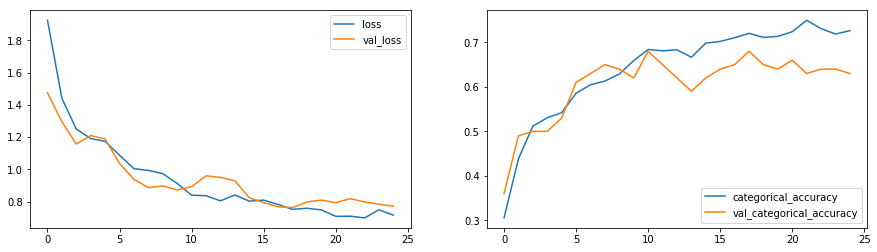

In [98]:
plot(mdz)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 25, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 50, 50, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 50, 50, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 50, 50, 32)    128       
__________

### Increasing the number of resolution of the input and decreasing the batch size.

In [45]:
image_height=160
image_width=160
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [49]:
model=define_model(25,160,160)

In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 25, 160, 160, 8)   656       
_________________________________________________________________
activation_29 (Activation)   (None, 25, 160, 160, 8)   0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 25, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 12, 80, 80, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 12, 80, 80, 16)    3472      
_________________________________________________________________
activation_30 (Activation)   (None, 12, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 12, 80, 80, 16)    64        
__________

In [52]:
md_30=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=35, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/35


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 12s - loss: 1.7157 - categorical_accuracy: 0.3625WIN_20180925_18_07_47_Pro_Left_Swipe_new;Left_Swipe_new;0



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 218s 6s/step - loss: 1.7068 - categorical_accuracy: 0.3642 - val_loss: 1.3027 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2021-02-0815_01_47.572012/model-00001-1.69924-0.36508-1.30273-0.44000.h5
Epoch 2/35
32/34 [===========================>..] - ETA: 6s - loss: 1.2284 - categorical_accuracy: 0.5164WIN_20180925_17_58_21_Pro_Right_Swipe_new;Right_Swipe_new;1

34/34 [==============================] - 110s 3s/step - loss: 1.3041 - categorical_accuracy: 0.5070 - val_loss: 0.9982 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2021-02-0815_01_47.572012/model-00002-1.23969-0.51172-0.99818-0.59000.h5
Epoch 3/35
32/34 [===========================>..] - ETA: 6s - loss: 1.1575 - categorical_accuracy: 0.5570WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4

34/34 [==============================] - 112s 3s/step - loss: 1.2508 - categorical_accuracy: 0.5401 - val_loss: 0.9331 - val_categorical

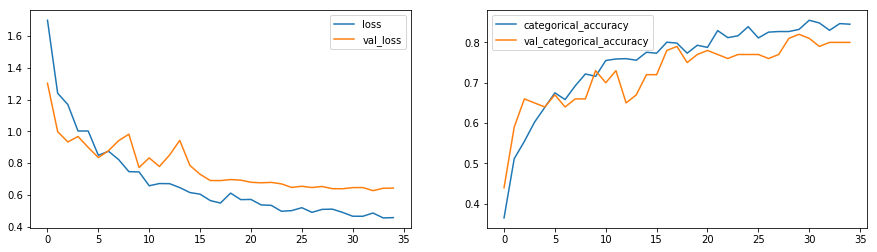

In [53]:
plot(md_30)

### This model seems to have the perfect balance between the memory footprint and the desirable performance.

### For the best model, the best validation accuracy is around 82% and the training accuracy is 83%.

# CNN WITH LSTM

In [101]:
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D

In [105]:
def CNN_RNN(frames_to_sample,image_height,image_width,lstm_cells=128,dense_neurons=128,dropout=0.25):
        
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample,image_height,image_width,3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [106]:
image_height=120
image_width=120
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [107]:
model=CNN_RNN(25,image_height,image_width)

In [108]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [109]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 25, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 25, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 25, 30, 30, 64)    18496     
__________

In [110]:
md_rnn_cnn=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 20
Epoch 1/20
 Project_data/val ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 5s - loss: 1.4682 - categorical_accuracy: 0.3531WIN_20180925_17_50_07_Pro_Thumbs_Down_new;Thumbs_Down_new;3



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 98s 3s/step - loss: 1.4647 - categorical_accuracy: 0.3569 - val_loss: 1.7323 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2021-02-0812_36_52.539199/model-00001-1.46269-0.35752-1.73230-0.28000.h5
Epoch 2/20
32/34 [===========================>..] - ETA: 4s - loss: 1.2790 - categorical_accuracy: 0.4562WIN_20180926_17_42_21_Pro_Thumbs_Down_new;Thumbs_Down_new;3

34/34 [==============================] - 81s 2s/step - loss: 1.2884 - categorical_accuracy: 0.4555 - val_loss: 1.8107 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-0812_36_52.539199/model-00002-1.27658-0.45881-1.81068-0.23000.h5
Epoch 3/20
32/34 [===========================>..] - ETA: 5s - loss: 1.1753 - categorical_accuracy: 0.5086WIN_20180926_16_46_07_Pro_Right_Swipe_new;Right_Swipe_new;1

34/34 [==============================] - 90s 3s/step - loss: 1.1702 - categorical_accuracy: 0.5129 - val_loss: 1.4431 - val_categorica

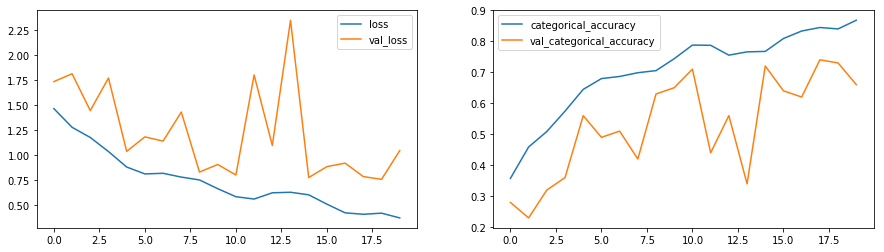

In [111]:
plot(md_rnn_cnn)

### This model seems to be over-fitting and it doesn't performs better in any category as compared to the model created before it.

### Hence, not continuing with the CNN+LSTM architechture

# Transfer Learning (Mobile Net,FrozenWeight)

In [112]:
from keras.applications import mobilenet

In [114]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [116]:
def mobile_net_model(frames_to_sample,image_height,image_width,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,image_height,image_width,3)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [119]:
image_height=120
image_width=120
image_frames=[0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29]
batch_size=20
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [120]:
model=mobile_net_model(25,image_height,image_width)

In [121]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 25, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_22 (TimeDis (None, 25, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 25, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 25, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
__________

In [123]:
mob_model=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 5s - loss: 1.5641 - categorical_accuracy: 0.2789WIN_20180925_17_46_09_Pro_Right_Swipe_new;Right_Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 102s 3s/step - loss: 1.5842 - categorical_accuracy: 0.2752 - val_loss: 1.4688 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2021-02-0812_36_52.539199/model-00001-1.56062-0.28269-1.46880-0.43000.h5
Epoch 2/25
32/34 [===========================>..] - ETA: 4s - loss: 1.2010 - categorical_accuracy: 0.5211WIN_20180926_17_20_41_Pro_Stop_new;Stop_new;2

34/34 [==============================] - 81s 2s/step - loss: 1.2194 - categorical_accuracy: 0.5063 - val_loss: 1.2946 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2021-02-0812_36_52.539199/model-00002-1.20001-0.52003-1.29461-0.48000.h5
Epoch 3/25
32/34 [===========================>..] - ETA: 5s - loss: 0.9626 - categorical_accuracy: 0.6164WIN_20180907_15_47_19_Pro_Thumbs Up_new;Thumbs Up_new;4

34/34 [==============================] - 90s 3s/step - loss: 1.0103 - categorical_accuracy: 0.6078 - val_loss: 1.1816 - val_categorical_accuracy: 0.470

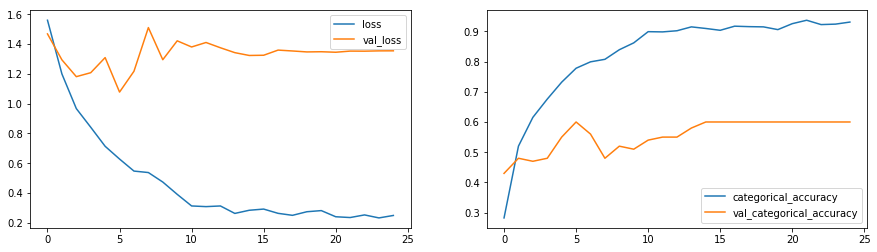

In [124]:
plot(mob_model)

### The transfer learning model with weights frozen seems to be overfitting by a lot based on the plots.

### This is not an ideal fit for our problem statement.

# Transfer Learning (Mobile Net, Training all weights)

In [125]:
def mobile_net_model(frames_to_sample,image_height,image_width,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,image_height,image_width,3)))
        
        
       
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [145]:
image_height=120
image_width=120
image_frames=[int(round(i)) for i in np.arange(0,30,1.9)]
batch_size=5
train_generator = generator(train_path, train_doc, batch_size,image_height, image_width, image_frames,aug=True)
val_generator = generator(val_path, val_doc, batch_size,image_height, image_width, image_frames)

In [146]:
model=mobile_net_model(16,image_height,image_width)

In [147]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [148]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_42 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                4160      
__________

In [149]:
mob_model_unfrozen=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val Source path =  Project_data/train ; batch size = 5
Epoch 1/20
; batch size = 5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


122/133 [==========================>...] - ETA: 8s - loss: 1.4594 - categorical_accuracy: 0.3574WIN_20180925_17_50_31_Pro_Right_Swipe_new;Right_Swipe_new;1



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 105s 787ms/step - loss: 1.4366 - categorical_accuracy: 0.3722 - val_loss: 1.3558 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2021-02-0812_36_52.539199/model-00001-1.43331-0.37415-1.35580-0.36000.h5
Epoch 2/20
122/133 [==========================>...] - ETA: 6s - loss: 1.1470 - categorical_accuracy: 0.5213WIN_20180926_17_27_34_Pro_Thumbs_Down_new;Thumbs_Down_new;3

133/133 [==============================] - 79s 594ms/step - loss: 1.1700 - categorical_accuracy: 0.5128 - val_loss: 1.2346 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2021-02-0812_36_52.539199/model-00002-1.15951-0.51550-1.23461-0.52000.h5
Epoch 3/20
122/133 [==========================>...] - ETA: 6s - loss: 1.0379 - categorical_accuracy: 0.5828WIN_20180907_15_49_56_Pro_Right Swipe_new;Right Swipe_new;1

133/133 [==============================] - 82s 614ms/step - loss: 1.0318 - categorical_accuracy: 0.5882 - val_loss: 0.9

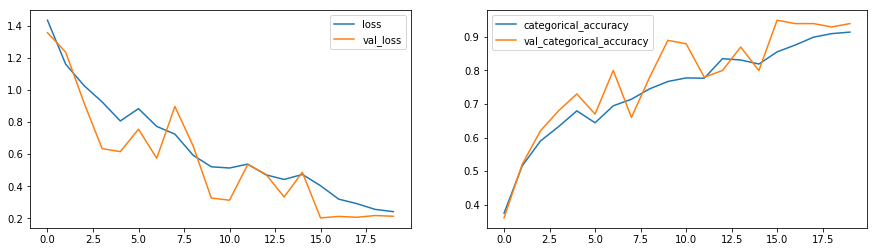

In [150]:
plot(mob_model_unfrozen)

### This seems to be the best model in terms of performance but the number of parameters involved are quite a lot.

### We have already built a custom model with a decent performance and memory footprint which we feel is better suited for real time processing.

# Hence, we will finally go with the model :- model-00030-0.49027-0.83220-0.63872-0.82000.h5